In [1]:
#Normal data 90-10 with for 90%(20%training, 80%validation) and 10%test data
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D,MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers

from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import os

In [4]:
#changing the working directory
%cd /content/gdrive/My Drive/Thesis

/content/gdrive/My Drive/Thesis


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.applications import VGG19
import cv2
import os
import random
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
labels = ['dandelion', 'daisy','tulip','sunflower','rose']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [8]:
data = get_data("/content/gdrive/My Drive/Thesis/flowers")

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



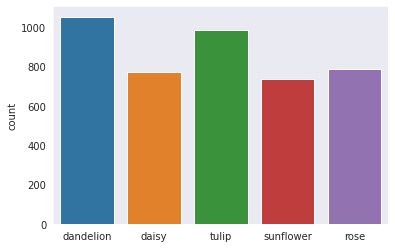

In [9]:
l = []
for i in data:
    l.append(labels[i[1]])
sns.set_style('dark')
sns.countplot(l)

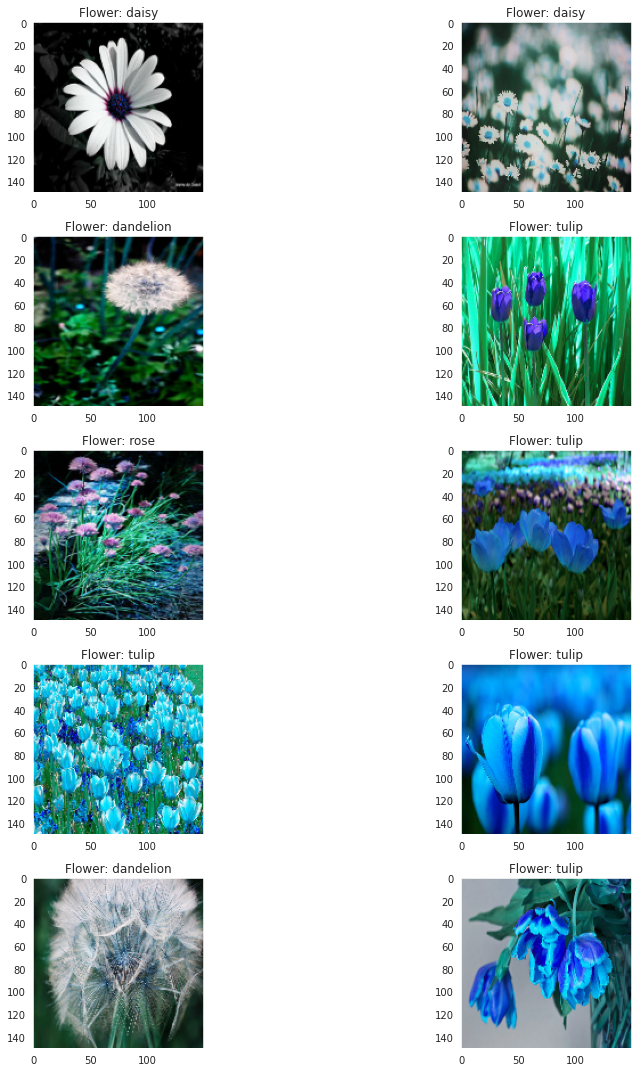

In [10]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Flower: '+labels[data[l][1]])
        
plt.tight_layout()

In [11]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

In [12]:
# Normalize the data
x = np.array(x) / 255

In [13]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's 
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)

In [14]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [15]:
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.1 , random_state = 42)

In [16]:
x_train,x_val,y_train,y_val = train_test_split(x_train, y_train, test_size= 0.8, random_state = 42)

In [17]:
model = Sequential()

#Adding ResNet model
model.add(ResNet50(include_top=False, pooling='avg', weights="imagenet", input_shape=(150,150,3)))
model.add(Flatten())

model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())

#Output layer
model.add(Dense(5, activation='softmax'))

model.summary()


94773248/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 25,695,109
Trainable params: 25,639,941
Non

In [18]:
#defining early stopping
from keras.callbacks import ReduceLROnPlateau
learning_rate = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.5, min_lr=0.000001)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=1, mode='min')

In [19]:
!pip install h5py
	
	
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [20]:
model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [26]:
#Fitting the augmentation data
history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data = (x_val, y_val), callbacks = [learning_rate,es,mc])

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9884 
Epoch 00001: val_accuracy did not improve from 0.23747
25/25 [==============================] - 472s 19s/step - loss: 0.0456 - accuracy: 0.9884 - val_loss: 4.1381 - val_accuracy: 0.2375
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9961 
Epoch 00002: val_accuracy did not improve from 0.23747
25/25 [==============================] - 473s 19s/step - loss: 0.0156 - accuracy: 0.9961 - val_loss: 4.3421 - val_accuracy: 0.2375
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 0.9974 
Epoch 00003: val_accuracy did not improve from 0.23747
25/25 [==============================] - 465s 19s/step - loss: 0.0212 - accuracy: 0.9974 - val_loss: 4.5748 - val_accuracy: 0.2375
Epoch 4/100
25/25 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9987 
Epoch 00004: ReduceLROnPlateau reducing learning rate to 1

In [27]:
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import matplotlib.image as mimg

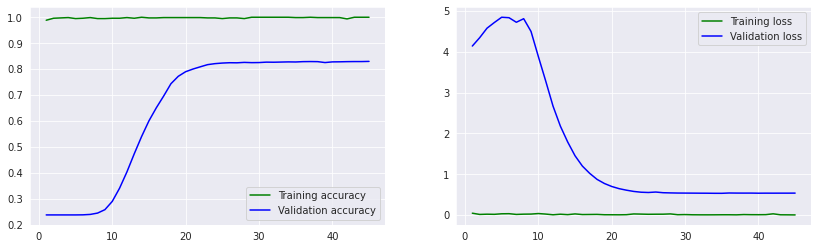

In [28]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, accuracy, 'g', label='Training accuracy')
axes[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'g', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [29]:
saved_model = tf.keras.models.load_model('best_model.h5')
print("Test Accuracy: {0:.2f}%".format(saved_model.evaluate(x_test,y_test)[1]*100)) #get score acording to test datas

14/14 [==============================] - 29s 2s/step - loss: 0.5492 - accuracy: 0.8152
Test Accuracy: 81.52%


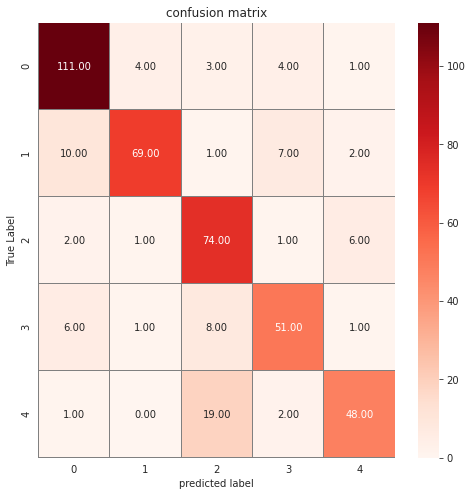

              precision    recall  f1-score   support

           0       0.85      0.90      0.88       123
           1       0.92      0.78      0.84        89
           2       0.70      0.88      0.78        84
           3       0.78      0.76      0.77        67
           4       0.83      0.69      0.75        70

    accuracy                           0.82       433
   macro avg       0.82      0.80      0.80       433
weighted avg       0.82      0.82      0.81       433

              precision    recall  f1-score   support

   dandelion       0.85      0.90      0.88       123
       daisy       0.92      0.78      0.84        89
       tulip       0.70      0.88      0.78        84
   sunflower       0.78      0.76      0.77        67
        rose       0.83      0.69      0.75        70

    accuracy                           0.82       433
   macro avg       0.82      0.80      0.80       433
weighted avg       0.82      0.82      0.81       433



In [30]:
from sklearn.metrics import confusion_matrix
Y_pred = saved_model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Reds",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))

y_test_inv = label_binarizer.inverse_transform(y_test)
print(classification_report(y_test_inv, Y_pred_classes, target_names = labels))